In [4]:
import math
import pandas as pd


weight_kg = 7.26   # 16 lbs ≈ 7.26 kg
unit_value_usd = 100.0  # estimated COGS for holding cost calc
holding_rate = 0.15     # 15% annual cost of capital
days_in_year = 365

# Air freight assumptions
air_rate_usd_per_kg = 7.0   # all-in (base + fuel + security); oversized surcharges modeled below
air_oversize_surcharge = 200.0  # per unit, due to 1.6 m length
p_air = 0.01   # probability of having to expedite by air due to delays

# Ocean freight (China) assumptions
ocean_rate_40HC_normal = 3500.0   # USD per 40' HC container (normal)
ocean_rate_40HC_crisis_mult = 3.0 # crisis multiplier (e.g., Red Sea / port disruptions)
units_per_container = 150         # due to size + packaging efficiency
us_port_drayage_per_container = 1500.0  # trucking & handling from port to plant per container (US side)
cn_ocean_days = 30                # normal ocean transit (port-to-port + handling buffer)
cn_extra_delay_days = 10          # additional delays (port congestion / customs)
cn_crisis_prob = 0.01             # probability of crisis conditions on a given period

# Mexico trucking assumptions
mx_distance_miles = 1000          # average plant-to-plant distance (e.g., MX plant to TX/NV/CA)
truck_cost_per_mile = 2.50        # full truckload line-haul cost per mile
mx_units_per_truck = 400          # loading efficiency
mx_border_fee_per_truck = 500.0   # brokerage + border fees
mx_border_delay_days = 2          # typical added time at border
mx_truck_delay_prob = 0.30        # probability of notable delay that triggers air (rare) or expediting domestically
mx_p_air = 0.01                   # small probability of switching a small batch to air (e.g., service recovery)

# US domestic trucking assumptions
us_distance_miles = 1500
us_units_per_truck = 400
us_truck_delay_days = 1
us_p_air = 0.01  # very rare expedited air domestically for this part


def holding_cost_per_unit(extra_days, unit_value=unit_value_usd, rate=holding_rate):
    return unit_value * rate * (extra_days / days_in_year)

def air_cost_per_unit(weight=weight_kg, rate_per_kg=air_rate_usd_per_kg, oversize=air_oversize_surcharge):
    return weight * rate_per_kg + oversize

def expected_air_cost(p_air, air_unit_cost):
    return p_air * air_unit_cost

def china_transport_cost():
    # Base ocean per unit (normal)
    ocean_normal_per_unit = ocean_rate_40HC_normal / units_per_container
    drayage_per_unit = us_port_drayage_per_container / units_per_container
    
    # Crisis expected multiplier
    expected_multiplier = (1 - cn_crisis_prob) * 1.0 + cn_crisis_prob * ocean_rate_40HC_crisis_mult
    expected_ocean_per_unit = (ocean_rate_40HC_normal * expected_multiplier) / units_per_container + drayage_per_unit
    
    # Holding cost due to time in transit
    exp_days = cn_ocean_days + cn_extra_delay_days * cn_crisis_prob  # expected extra days
    holding = holding_cost_per_unit(exp_days)
    
    # Expected expedited air (if schedule risk forces small batch air)
    air_unit = air_cost_per_unit()
    exp_air = expected_air_cost(p_air, air_unit)
    
    total = expected_ocean_per_unit + holding + exp_air
    detail = {
        "Base_ocean_per_unit_normal": round(ocean_normal_per_unit, 2),
        "Drayage_per_unit": round(drayage_per_unit, 2),
        "Expected_ocean_per_unit": round(expected_ocean_per_unit, 2),
        "Holding_cost": round(holding, 2),
        "Expected_air_cost": round(exp_air, 2),
        "Total_transport_per_unit": round(total, 2),
    }
    return detail

def mexico_transport_cost():
    # Base trucking per unit
    truck_total = truck_cost_per_mile * mx_distance_miles
    per_truck_all_in = truck_total + mx_border_fee_per_truck
    base_per_unit = per_truck_all_in / mx_units_per_truck
    
    # Holding due to border delay
    holding = holding_cost_per_unit(mx_border_delay_days)
    
    # Rare expedited air
    air_unit = air_cost_per_unit()
    exp_air = expected_air_cost(mx_p_air, air_unit)
    
    total = base_per_unit + holding + exp_air
    detail = {
        "Base_truck_per_unit": round(base_per_unit, 2),
        "Holding_cost": round(holding, 2),
        "Expected_air_cost": round(exp_air, 2),
        "Total_transport_per_unit": round(total, 2),
    }
    return detail

def us_transport_cost():
    # Base trucking per unit
    truck_total = truck_cost_per_mile * us_distance_miles
    base_per_unit = truck_total / us_units_per_truck
    
    # Minimal delay holding
    holding = holding_cost_per_unit(us_truck_delay_days)
    
    # Very rare expedited air
    air_unit = air_cost_per_unit()
    exp_air = expected_air_cost(us_p_air, air_unit)
    
    total = base_per_unit + holding + exp_air
    detail = {
        "Base_truck_per_unit": round(base_per_unit, 2),
        "Holding_cost": round(holding, 2),
        "Expected_air_cost": round(exp_air, 2),
        "Total_transport_per_unit": round(total, 2),
    }
    return detail

cn = china_transport_cost()
mx = mexico_transport_cost()
us = us_transport_cost()

df = pd.DataFrame.from_records([
    {"Route": "China → US (Ocean + Drayage)", **cn},
    {"Route": "Mexico → US (Truck + Border)", **mx},
    {"Route": "US Domestic (Truck)", **us},
])

df


,Route,Base_ocean_per_unit_normal,Drayage_per_unit,Expected_ocean_per_unit,Holding_cost,Expected_air_cost,Total_transport_per_unit,Base_truck_per_unit
0,China → US (Ocean + Drayage),23.33,10.0,33.8,1.24,2.51,37.55,NaN
1,Mexico → US (Truck + Border),NaN,NaN,NaN,0.08,2.51,10.09,7.50
2,US Domestic (Truck),NaN,NaN,NaN,0.04,2.51,11.92,9.38


In [5]:
# AHP for Tesla Sourcing (US vs Mexico vs China) across 4 criteria
# Criteria: Cost, Risk, Logistics, Supply Chain Readiness
# We compute priorities via principal eigenvector and check Consistency Ratio (CR).

import numpy as np
import pandas as pd

def ahp_weights(matrix):
    # Principal eigenvector method
    eigvals, eigvecs = np.linalg.eig(matrix)
    max_index = np.argmax(eigvals.real)
    max_eigval = eigvals.real[max_index]
    weights = np.array(eigvecs[:, max_index].real).flatten()
    weights = weights / weights.sum()
    return weights, max_eigval

def consistency_ratio(matrix):
    n = matrix.shape[0]
    weights, lambda_max = ahp_weights(matrix)
    CI = (lambda_max - n) / (n - 1) if n > 1 else 0.0
    # Saaty RI values for n=1..10
    RI_table = {1:0.0, 2:0.0, 3:0.58, 4:0.90, 5:1.12, 6:1.24, 7:1.32, 8:1.41, 9:1.45, 10:1.49}
    RI = RI_table.get(n, 1.49)
    CR = CI / RI if RI > 0 else 0.0
    return CI, CR, weights, lambda_max

def build_pcm_from_upper(vals, n):
    """Build a positive reciprocal pairwise comparison matrix from the strict upper triangle values list (row-major)."""
    M = np.ones((n, n))
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            M[i, j] = vals[idx]
            M[j, i] = 1.0 / vals[idx]
            idx += 1
    return M

alts = ["US", "Mexico", "China"]
criteria = ["Cost", "Risk", "Logistics", "Readiness"]

# --- Criteria pairwise matrix (4x4) ---
# Judgments chosen to roughly target ~[0.35, 0.25, 0.20, 0.20]
# Upper triangle order: (0,1),(0,2),(0,3),(1,2),(1,3),(2,3)
criteria_upper = [3, 3, 3, 2, 2, 1]  # Cost>Risk, Cost>Logistics, Cost>Readiness, Risk>Logistics, Risk>Readiness, Logistics=Readiness
C = build_pcm_from_upper(criteria_upper, 4)
CIc, CRc, wC, lamC = consistency_ratio(C)

# --- Alternative pairwise matrices per criterion (3x3) ---
# COST: CN best < MX < US
# upper triangle order: (0,1),(0,2),(1,2) for [US, MX, CN]
# We need relative: CN better than MX (3) and US (5); MX better than US (3).
# Translate to matrix with US first:
# US vs MX -> MX preferred -> value <1 (1/3)
# US vs CN -> CN strongly preferred -> value <1 (1/5)
# MX vs CN -> CN moderately preferred -> value <1 for MX vs CN (1/3)
cost_upper = [1/3, 1/5, 1/3]
A_cost = build_pcm_from_upper(cost_upper, 3)
CI_cost, CR_cost, w_cost, lam_cost = consistency_ratio(A_cost)

# RISK: US best > MX > CN
# US vs MX = 4; US vs CN = 7; MX vs CN = 5
risk_upper = [4, 7, 5]
A_risk = build_pcm_from_upper(risk_upper, 3)
CI_risk, CR_risk, w_risk, lam_risk = consistency_ratio(A_risk)

# LOGISTICS: US best > MX > CN
# US vs MX = 3; US vs CN = 6; MX vs CN = 3
log_upper = [3, 6, 3]
A_log = build_pcm_from_upper(log_upper, 3)
CI_log, CR_log, w_log, lam_log = consistency_ratio(A_log)

# READINESS: US > CN > MX
# US vs MX = 4; US vs CN = 2; CN vs MX = 3
ready_upper = [4, 2, 3]
A_ready = build_pcm_from_upper(ready_upper, 3)
CI_ready, CR_ready, w_ready, lam_ready = consistency_ratio(A_ready)

# Collect local weights into a DataFrame
local_df = pd.DataFrame({
    "Alternative": alts,
    "Cost_w": w_cost,
    "Risk_w": w_risk,
    "Logistics_w": w_log,
    "Readiness_w": w_ready
})

# Global weights and final score
crit_df = pd.DataFrame({"Criteria": criteria, "Weight": wC})
final_scores = local_df[["Cost_w","Risk_w","Logistics_w","Readiness_w"]].values @ wC
local_df["Global Score"] = final_scores

# Rank
local_df["Rank"] = (-local_df["Global Score"]).argsort().argsort() + 1  # 1 = best

# Consistency summary
consistency_df = pd.DataFrame({
    "Matrix": ["Criteria", "Cost", "Risk", "Logistics", "Readiness"],
    "CI": [CIc, CI_cost, CI_risk, CI_log, CI_ready],
    "CR": [CRc, CR_cost, CR_risk, CR_log, CR_ready],
    "lambda_max": [lamC, lam_cost, lam_risk, lam_log, lam_ready]
})

crit_df, local_df, consistency_df


(    Criteria    Weight
 0       Cost  0.494997
 1       Risk  0.232185
 2  Logistics  0.136409
 3  Readiness  0.136409,
   Alternative    Cost_w    Risk_w  Logistics_w  Readiness_w  Global Score  \
 0          US  0.104729  0.687086     0.654807     0.578222      0.379568   
 1      Mexico  0.258285  0.243741     0.249856     0.262675      0.254357   
 2       China  0.636986  0.069173     0.095338     0.159104      0.366075   
 
    Rank  
 0     1  
 1     3  
 2     2  ,
       Matrix        CI        CR  lambda_max
 0   Criteria  0.020216  0.022462    4.060647
 1       Cost  0.019256  0.033199    3.038511
 2       Risk  0.061857  0.106649    3.123713
 3  Logistics  0.009147  0.015771    3.018295
 4  Readiness  0.183721  0.316760    3.367442)

Monte Carlo Summary (USD per unit)


mean     p10     p50     p90
US     Ramp    103.74   93.62  102.45  115.40
       Steady   82.50   80.23   82.40   84.90
Mexico Ramp     97.51   89.52   96.83  106.30
       Steady   87.52   82.31   87.19   93.18
China  Ramp    123.43  103.61  121.07  145.85
       Steady  117.17   98.71  114.95  137.87


Probability Cheapest


,Region,Prob_Cheapest_Ramp,Prob_Cheapest_Steady
0,US,0.272,0.878
1,Mexico,0.694,0.121
2,China,0.035,0.001


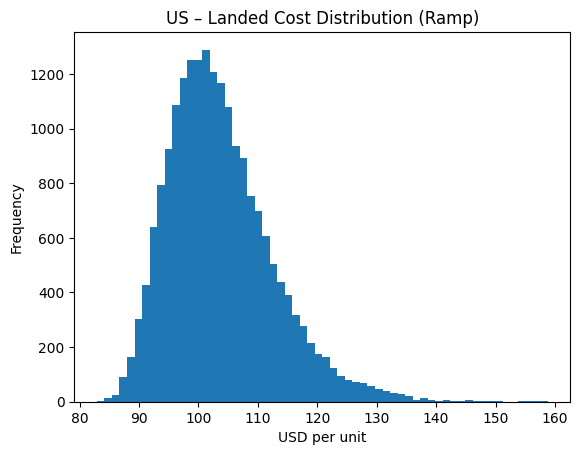

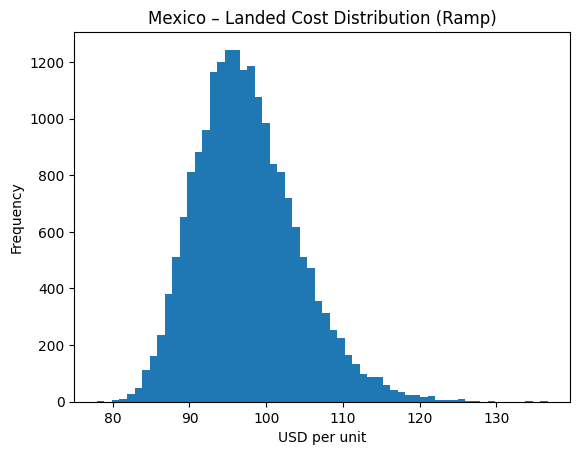

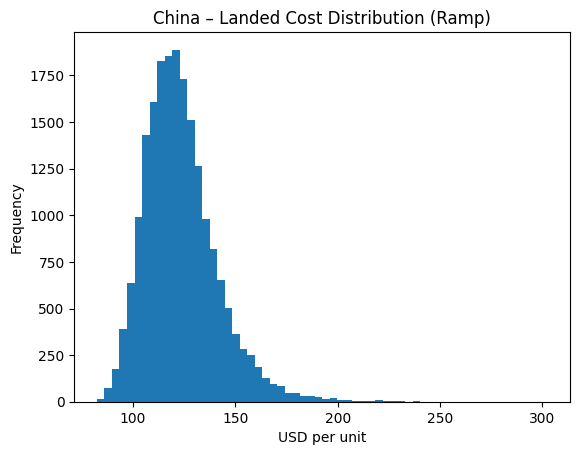

In [6]:
# Monte Carlo simulation for stochastic forecasting of landed cost per unit

# This notebook cell builds a parameterized simulation and produces:
# 1) Summary statistics (mean, p10, p50, p90) for ramp (first 6 months) and steady state
# 2) Probability each region is cheapest
# 3) Separate histograms of landed-cost distributions (ramp period)
#
# You can tweak the "ASSUMPTIONS" section and rerun.


import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# ----------------------
# ASSUMPTIONS (centered on recent real-world benchmarks)
# ----------------------
# Part parameters
weight_kg = 7.26           # 16 lbs
unit_value_usd = 100.0     # for holding cost calc
days_in_year = 365

# Finance
holding_rate_mu = 0.15     # annual carrying cost
holding_rate_sd = 0.03

# Air freight (benchmarks ~ $6.5/kg; oversize surcharge around $150)
air_rate_mu = 6.5
air_rate_sd = 1.0
air_oversize_mu = 150.0
air_oversize_sd = 40.0

# Expedite probabilities (as EV triggers when schedule slips)
p_air_CN_min, p_air_CN_mode, p_air_CN_max = 0.00, 0.10, 0.20
p_air_MX_min, p_air_MX_mode, p_air_MX_max = 0.00, 0.03, 0.08
p_air_US_min, p_air_US_mode, p_air_US_max = 0.00, 0.01, 0.03

# China ocean rates
feu_mu = 3500.0        # $ per 40' container baseline
feu_sigma = 0.5        # lognormal sigma (multiplicative volatility)
crisis_mult_low, crisis_mult_high = 1.0, 2.0
p_crisis = 0.05
units_per_container_min, units_per_container_mode, units_per_container_max = 120, 150, 180
us_drayage_per_container = 1500.0
cn_ocean_days = 30
cn_extra_delay_days = 10

# Mexico trucking
mx_miles = 1000
mx_rate_mu = 2.29     # $/mile
mx_rate_sd = 0.40
mx_border_fee_per_truck = 600.0
mx_units_per_truck_min, mx_units_per_truck_mode, mx_units_per_truck_max = 250, 300, 350
mx_border_delay_days_min, mx_border_delay_days_mode, mx_border_delay_days_max = 1, 2, 4

# US domestic trucking
us_miles = 1500
us_rate_mu = 2.35
us_rate_sd = 0.30
us_units_per_truck_min, us_units_per_truck_mode, us_units_per_truck_max = 350, 400, 450
us_delay_days = 1

# Tariffs (given policy is 25%; use case-provided tariff figures as means with 10% sd)
tariff_US = 0.0
tariff_MX_mu = 15.50
tariff_CN_mu = 15.00
tariff_sd_frac = 0.10

# Base in-plant cost components (from case exhibit; exclude regional P/T/I row since we model transport explicitly)
# US: raw 40 + labor 12 + indirect 10 + electricity 4 + depreciation 5 = 71
# MX: 35 + 8 + 8 + 3 + 1 = 55
# CN: 30 + 4 + 4 + 4 + 5 = 47
base_US = 40 + 12 + 10 + 4 + 5
base_MX = 35 + 8 + 8 + 3 + 1
base_CN = 30 + 4 + 4 + 4 + 5

# Yields during ramp (first 6 months), modeled as Beta distributions centered at 0.80/0.90/0.95
# Choose alphas/betas to give reasonable dispersion
alpha_US, beta_US = 32, 8    # mean ~0.80
alpha_MX, beta_MX = 45, 5    # mean ~0.90
alpha_CN, beta_CN = 57, 3    # mean ~0.95

# Simulation size
N = 20000


# ----------------------
# Helper random draws
# ----------------------
def triangular(a, c, b, size):
    # a=min, c=mode, b=max
    u = rng.random(size)
    Fc = (c - a) / (b - a)
    left = u < Fc
    x = np.empty(size)
    x[left] = a + np.sqrt(u[left] * (b - a) * (c - a))
    x[~left] = b - np.sqrt((1 - u[~left]) * (b - a) * (b - c))
    return x

def lognormal_from_mean_sigma(mean, sigma, size):
    # sigma is the log-space std (multiplicative volatility)
    # mean_logn = exp(mu + sigma^2 / 2) => mu = ln(mean) - sigma^2/2
    mu = math.log(mean) - 0.5 * sigma**2
    return rng.lognormal(mean=mu, sigma=sigma, size=size)

def clipped_normal(mu, sd, size, min_val=0.0):
    vals = rng.normal(mu, sd, size)
    return np.maximum(vals, min_val)

# ----------------------
# Transport cost models per draw
# ----------------------
def china_transport_per_unit(
    feu_draw, crisis_mult_draw, units_per_container_draw,
    air_rate_draw, oversize_draw, p_air_draw, holding_rate_draw
):
    # Ocean base per unit with crisis
    ocean_per_unit = (feu_draw * crisis_mult_draw) / units_per_container_draw
    drayage_per_unit = us_drayage_per_container / units_per_container_draw
    expected_ocean = ocean_per_unit + drayage_per_unit
    
    # Holding (expected days: 30 + p_crisis * 10)
    exp_days = cn_ocean_days + p_crisis * cn_extra_delay_days
    holding = unit_value_usd * holding_rate_draw * (exp_days / days_in_year)
    
    # Expected air expedite EV
    air_unit = air_rate_draw * weight_kg + oversize_draw
    exp_air = p_air_draw * air_unit
    
    return expected_ocean + holding + exp_air

def mexico_transport_per_unit(
    mx_rate_draw, units_per_truck_draw, border_fee_draw,
    air_rate_draw, oversize_draw, p_air_draw, holding_rate_draw, border_delay_days_draw
):
    per_truck = mx_rate_draw * mx_miles + border_fee_draw
    base_per_unit = per_truck / units_per_truck_draw
    holding = unit_value_usd * holding_rate_draw * (border_delay_days_draw / days_in_year)
    air_unit = air_rate_draw * weight_kg + oversize_draw
    exp_air = p_air_draw * air_unit
    return base_per_unit + holding + exp_air

def us_transport_per_unit(
    us_rate_draw, units_per_truck_draw,
    air_rate_draw, oversize_draw, p_air_draw, holding_rate_draw
):
    per_truck = us_rate_draw * us_miles
    base_per_unit = per_truck / units_per_truck_draw
    holding = unit_value_usd * holding_rate_draw * (us_delay_days / days_in_year)
    air_unit = air_rate_draw * weight_kg + oversize_draw
    exp_air = p_air_draw * air_unit
    return base_per_unit + holding + exp_air


# ----------------------
# Run draws
# ----------------------
# Common draws
holding_rate_draw = clipped_normal(holding_rate_mu, holding_rate_sd, N, 0.01)
air_rate_draw = clipped_normal(air_rate_mu, air_rate_sd, N, 0.1)
oversize_draw = clipped_normal(air_oversize_mu, air_oversize_sd, N, 0.0)

# China-specific
feu_draw = lognormal_from_mean_sigma(feu_mu, feu_sigma, N)
crisis_mult_draw = np.where(rng.random(N) < p_crisis,
                            rng.uniform(crisis_mult_low, crisis_mult_high, N),
                            1.0)
units_per_container_draw = triangular(units_per_container_min, units_per_container_mode, units_per_container_max, N)
p_air_CN_draw = triangular(p_air_CN_min, p_air_CN_mode, p_air_CN_max, N)

# Mexico-specific
mx_rate_draw = clipped_normal(mx_rate_mu, mx_rate_sd, N, 0.5)
units_per_truck_MX_draw = triangular(mx_units_per_truck_min, mx_units_per_truck_mode, mx_units_per_truck_max, N)
mx_border_fee_draw = np.full(N, mx_border_fee_per_truck)
border_delay_draw = triangular(mx_border_delay_days_min, mx_border_delay_days_mode, mx_border_delay_days_max, N)
p_air_MX_draw = triangular(p_air_MX_min, p_air_MX_mode, p_air_MX_max, N)

# US-specific
us_rate_draw = clipped_normal(us_rate_mu, us_rate_sd, N, 0.5)
units_per_truck_US_draw = triangular(us_units_per_truck_min, us_units_per_truck_mode, us_units_per_truck_max, N)
p_air_US_draw = triangular(p_air_US_min, p_air_US_mode, p_air_US_max, N)

# Transport per unit draws
CN_transport = china_transport_per_unit(
    feu_draw, crisis_mult_draw, units_per_container_draw,
    air_rate_draw, oversize_draw, p_air_CN_draw, holding_rate_draw
)

MX_transport = mexico_transport_per_unit(
    mx_rate_draw, units_per_truck_MX_draw, mx_border_fee_draw,
    air_rate_draw, oversize_draw, p_air_MX_draw, holding_rate_draw, border_delay_draw
)

US_transport = us_transport_per_unit(
    us_rate_draw, units_per_truck_US_draw,
    air_rate_draw, oversize_draw, p_air_US_draw, holding_rate_draw
)

# Tariffs (randomized around means for MX/CN)
tariff_MX_draw = clipped_normal(tariff_MX_mu, tariff_sd_frac * tariff_MX_mu, N, 0.0)
tariff_CN_draw = clipped_normal(tariff_CN_mu, tariff_sd_frac * tariff_CN_mu, N, 0.0)

# Ramp yields (Beta)
US_yield = rng.beta(alpha_US, beta_US, N)
MX_yield = rng.beta(alpha_MX, beta_MX, N)
CN_yield = rng.beta(alpha_CN, beta_CN, N)

# Landed cost during ramp (divide by yield)
US_ramp = (base_US + tariff_US + US_transport) / US_yield
MX_ramp = (base_MX + tariff_MX_draw + MX_transport) / MX_yield
CN_ramp = (base_CN + tariff_CN_draw + CN_transport) / CN_yield

# Landed cost steady state (yield ~ 1)
US_steady = (base_US + tariff_US + US_transport)
MX_steady = (base_MX + tariff_MX_draw + MX_transport)
CN_steady = (base_CN + tariff_CN_draw + CN_transport)

# ----------------------
# Summaries
# ----------------------
def summarize(arr):
    return {
        "mean": np.mean(arr),
        "p10": np.percentile(arr, 10),
        "p50": np.percentile(arr, 50),
        "p90": np.percentile(arr, 90),
    }

summary = pd.DataFrame({
    ("US","Ramp"): summarize(US_ramp),
    ("US","Steady"): summarize(US_steady),
    ("Mexico","Ramp"): summarize(MX_ramp),
    ("Mexico","Steady"): summarize(MX_steady),
    ("China","Ramp"): summarize(CN_ramp),
    ("China","Steady"): summarize(CN_steady),
}).T

# Probability each option is cheapest
cheapest_ramp = np.argmin(np.vstack([US_ramp, MX_ramp, CN_ramp]).T, axis=1)
cheapest_steady = np.argmin(np.vstack([US_steady, MX_steady, CN_steady]).T, axis=1)

prob_ramp = pd.Series(cheapest_ramp).value_counts(normalize=True).reindex([0,1,2]).fillna(0)
prob_steady = pd.Series(cheapest_steady).value_counts(normalize=True).reindex([0,1,2]).fillna(0)

prob_df = pd.DataFrame({
    "Region": ["US","Mexico","China"],
    "Prob_Cheapest_Ramp": prob_ramp.values,
    "Prob_Cheapest_Steady": prob_steady.values
})

# Display tables
print("Monte Carlo Summary (USD per unit)")
display(summary.round(2))
print("\nProbability Cheapest")
display(prob_df.round(3))

# Histograms (Ramp) – separate charts, one per region (no colors set, single plots)
plt.figure()
plt.hist(US_ramp, bins=60)
plt.title("US – Landed Cost Distribution (Ramp)")
plt.xlabel("USD per unit")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(MX_ramp, bins=60)
plt.title("Mexico – Landed Cost Distribution (Ramp)")
plt.xlabel("USD per unit")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(CN_ramp, bins=60)
plt.title("China – Landed Cost Distribution (Ramp)")
plt.xlabel("USD per unit")
plt.ylabel("Frequency")
plt.show()
